In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, root_mean_squared_error
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from Funciones import feature_engineering_shuffle

In [3]:
df = pd.read_parquet("data/train_data/trips_weather_merged.parquet") #Load full Dataset

In [5]:
df = feature_engineering_shuffle(df) #Apply feature engineering function

In [7]:
df = pd.get_dummies(df,columns=["weekday","is_weekend", "rush_hour","is_holiday","LocationID"],drop_first=True,dtype=float)

In [9]:
df_cluster_2 = df[df["cluster"]==2] #Filter df to get cluster 2 data only
y = df_cluster_2["Total_Trips"]
X = df_cluster_2.drop(columns=["Total_Trips","tpep_pickup_hour", "Location*Hour","cluster"])
#Train-Test split, stratified using Location*Hour
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, shuffle=True, test_size=0.2, stratify=df_cluster_2["Location*Hour"])

In [11]:
def objective(trial):
    # Define hyperparameter search space
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'gamma': trial.suggest_float('gamma', 0, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'objective': 'reg:squarederror'
    }

    # Define cross-validation strategy
    cv = KFold(n_splits=4, shuffle=True, random_state=42)

    model = xgb.XGBRegressor(**params, random_state=42)

# Perform cross-validation manually to inverse transform predictions
    scores = []
    for train_index, val_index in cv.split(X_train, y_train): # Use the log-transformed target
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_train_fold, y_train_fold, verbose=0)
        predictions = model.predict(X_val_fold)

        score = r2_score(y_val_fold, predictions) # Inverse transform true values too for evaluation
        scores.append(score)

    # Return the mean accuracy across all folds
    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)

best_params = study.best_params

[I 2025-04-22 02:16:05,397] A new study created in memory with name: no-name-c6d23aef-4d64-43af-8389-23510d777a1d
[I 2025-04-22 02:17:54,373] Trial 0 finished with value: 0.9307895023914374 and parameters: {'learning_rate': 0.038475745051138294, 'n_estimators': 309, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.12570198030830557, 'subsample': 0.7045390824732009, 'colsample_bytree': 0.893089849471707, 'reg_alpha': 8.853327424290008, 'reg_lambda': 1.8248382080066405}. Best is trial 0 with value: 0.9307895023914374.
[I 2025-04-22 02:19:49,086] Trial 1 finished with value: 0.9269162182752945 and parameters: {'learning_rate': 0.023096923139316772, 'n_estimators': 337, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.013582245616645438, 'subsample': 0.7630361568050777, 'colsample_bytree': 0.7661310902367793, 'reg_alpha': 2.5196284627190146, 'reg_lambda': 5.41258810542341}. Best is trial 0 with value: 0.9307895023914374.
[I 2025-04-22 02:21:51,237] Trial 2 finished with value: 0.94149879

Best hyperparameters: {'learning_rate': 0.1498124962476959, 'n_estimators': 352, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 0.02378074852415671, 'subsample': 0.6051839424327529, 'colsample_bytree': 0.9939555418901009, 'reg_alpha': 4.881402844706467, 'reg_lambda': 0.4904264751738619}


In [25]:
model = xgb.XGBRegressor(**best_params)

model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9939555418901009, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.02378074852415671,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1498124962476959,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=352, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [28]:
y_pred = model.predict(X_test)

In [30]:
r2_score(y_test, y_pred)

0.9455431369637368

In [32]:
root_mean_squared_error(y_test, y_pred)

0.27954325433013594

In [34]:
y_pred_exp = np.exp(y_pred)
y_test_exp = np.exp(y_test)

In [36]:
root_mean_squared_error(y_test_exp, y_pred_exp)

14.408698120929909

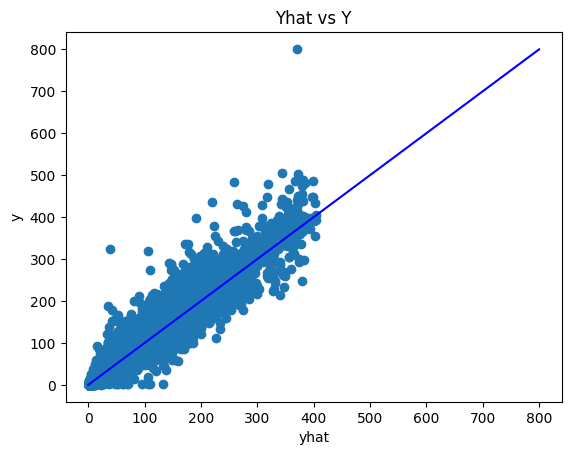

In [38]:
plt.title("Yhat vs Y")
plt.plot(y_pred_exp, y_test_exp,"o")
plt.plot([0,800],[0,800],"b")
plt.xlabel("yhat")
plt.ylabel("y")
plt.show()

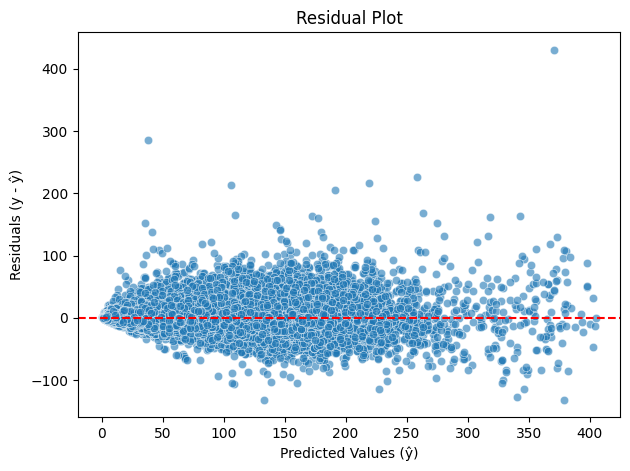

In [40]:
def plot_residuals(y_test_exp, y_pred_exp):
    residuals = y_test_exp - y_pred_exp
    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=y_pred_exp, y=residuals, alpha=0.6)
    plt.axhline(y=0, color="red", linestyle="--")
    plt.xlabel("Predicted Values (ŷ)")
    plt.ylabel("Residuals (y - ŷ)")
    plt.title("Residual Plot")
    plt.show()

# Call function
plot_residuals(y_test_exp, y_pred_exp)

In [42]:
import shap
# 1. Create a SHAP explainer
explainer = shap.TreeExplainer(model)

In [44]:
# 2. Calculate SHAP values for the test set (or any data you want to explain)
shap_values = explainer.shap_values(X_test)

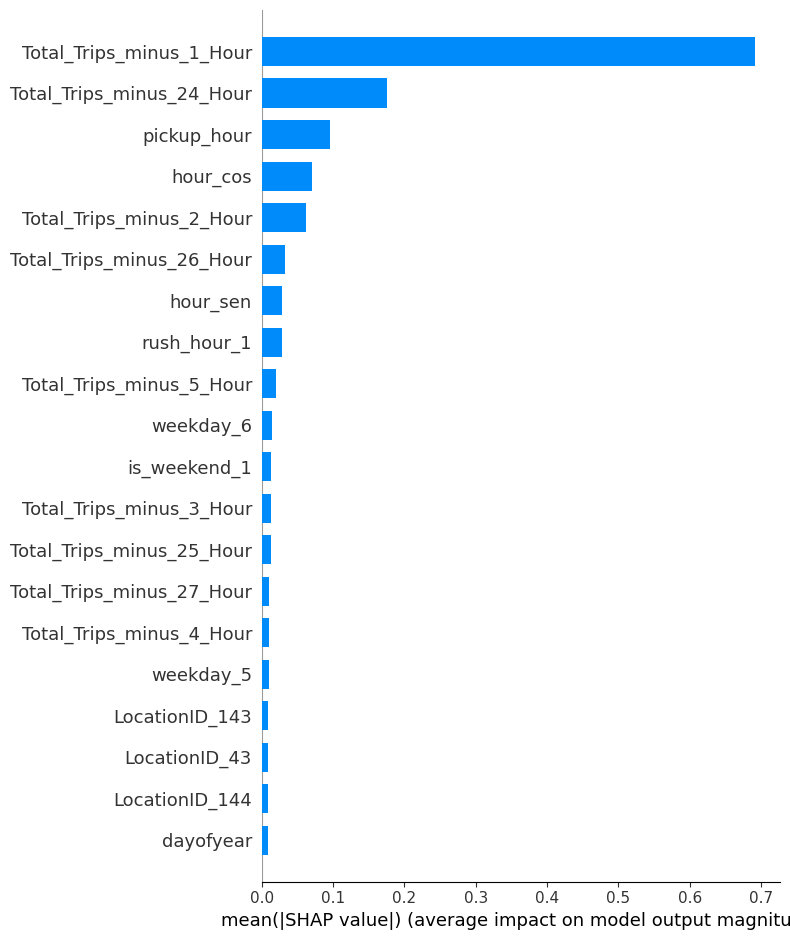

In [48]:
# 3. Bar Plot: Global feature importance (alternative representation)
shap.summary_plot(shap_values, X_test, plot_type="bar")